In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import cv2
np.random.seed(42)

In [2]:
############ Load Voronoi Images ###########
data = np.load('voronoi_imgs.npy', allow_pickle=True)
x_train = data[0]
x_tune = data[1]
x_test = data[2]
y_train = data[3]
y_tune = data[4]
y_test = data[5]
y_train_regions = data[6]
y_tune_regions = data[7]
y_test_regions = data[8]
del data

y_train = (y_train/255.0).astype('float32')
y_tune = (y_tune/255.0).astype('float32')
y_test = (y_test/255.0).astype('float32')

x_train = (x_train/255.0).astype('float32')
x_tune = (x_tune/255.0).astype('float32')
x_test = (x_test/255.0).astype('float32')

Number of Voronoi Cells = 13
Number of Voronoi Cells = 11
Number of Voronoi Cells = 10


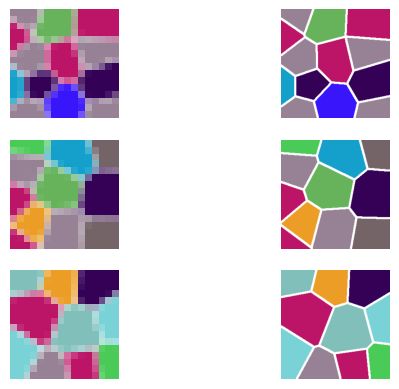

In [4]:
############# Plot Voronoi Low/High Resolution Images ###########
plt.subplot(3,2,1)
plt.imshow(x_train[0])
plt.axis('off')
plt.subplot(3,2,2)
plt.imshow(y_train[0])
plt.axis('off')
print('Number of Voronoi Cells = '+str(y_train_regions[0]))
plt.subplot(3,2,3)
plt.imshow(x_tune[0])
plt.axis('off')
plt.subplot(3,2,4)
plt.imshow(y_tune[0])
plt.axis('off')
print('Number of Voronoi Cells = '+str(y_tune_regions[0]))
plt.subplot(3,2,5)
plt.imshow(x_test[0])
plt.axis('off')
plt.subplot(3,2,6)
plt.imshow(y_test[0])
plt.axis('off')
print('Number of Voronoi Cells = '+str(y_test_regions[0]))

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_autoencoder():
    input_img = layers.Input(shape=(16, 16, 3))  # Input size: 16x16, 3 channels (RGB)

    # Encoder (Downsampling)
    c1 = layers.Conv2D(128, 3, strides=2, padding='same', activation = 'relu')(input_img)
    c2 = layers.Conv2D(256, 3, strides=2, padding='same', activation = 'relu')(c1)
    c3 = layers.Conv2D(512, 3, strides=2, padding='same', activation = 'relu')(c2) 
    
    # bottleneck
    bottleneck = layers.Conv2D(1024, 3, activation='relu', strides=2, padding='same')(c3)      
   
    # Decoder (Upsampling)
    d1 = layers.Conv2DTranspose(512, 3, strides=2, padding='same', activation = 'relu')(bottleneck)
    d1 = layers.concatenate([d1, c3])

    d2 = layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation = 'relu')(d1)
    d2 = layers.concatenate([d2, c2])
    
    d3 = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation = 'relu')(d2)
    d3 = layers.concatenate([d3, c1])
    
    d4 = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation = 'relu')(d3)        
    d5 = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation = 'relu')(d4)    
    d6 = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation = 'relu')(d5)     
    d7 = layers.Conv2DTranspose(16, 3, strides=2, padding='same', activation = 'relu')(d6)
    
    # Output layer
    output = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', strides=2, padding='same')(d7)     
    model = models.Model(inputs=input_img, outputs=output)
    model.summary()        
    return model

In [6]:
############## Loss Functions ###############
def mean_squared_error(true, pred):
    mse_loss = tf.reduce_mean(tf.square(tf.subtract(true,pred)))
    return mse_loss

def compute_gradients(image):
    # Sobel filters for gradient computation
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    sobel_x = tf.convert_to_tensor(sobel_x, dtype=tf.float32)
    sobel_y = tf.convert_to_tensor(sobel_y, dtype=tf.float32)

    # Apply Sobel filter in x and y directions
    grad_x = tf.nn.conv2d(image, sobel_x[None, :, :, None], strides=[1, 1, 1, 1], padding='SAME')
    grad_y = tf.nn.conv2d(image, sobel_y[None, :, :, None], strides=[1, 1, 1, 1], padding='SAME')
    epsilon = 1e-8
    gradient = tf.sqrt(tf.add(tf.square(grad_x),tf.square(grad_y))+epsilon)
    return gradient

def mean_gradient_error(true, pred):
    grad_true = compute_gradients(true)
    grad_pred = compute_gradients(pred)
    mge_loss = tf.reduce_mean(tf.square(tf.subtract(grad_true,grad_pred)))
    return mge_loss

def total_loss(true,pred):
    total_loss = mean_squared_error(true,pred)+0.1*mean_gradient_error(true,pred)
    return total_loss

In [7]:
model = build_autoencoder()
model.compile(optimizer='adam', loss=total_loss, metrics = 'mae')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 16, 16, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 8, 8, 128)    3584        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 4, 4, 256)    295168      conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 2, 2, 512)    1180160     conv2d_1[0][0]                   
______________________________________________________________________________________________

In [9]:
from tqdm import tqdm
def train(model, x_train, y_train, x_tune, y_tune, batch_size, n_epochs):
    train_mse = []
    tune_mse = []
    for i in range(n_epochs):
        no_of_iterations = x_train.shape[0]//batch_size		            
        for j in tqdm(range(no_of_iterations)):
            
            idx = np.random.choice(x_train.shape[0],batch_size)  
            lr = x_train[idx]     
            hr = y_train[idx]            
            model.train_on_batch(lr, hr)                                       

        predictions = model.predict_on_batch(x_train) 
        train_mse.append(mean_squared_error(y_train,predictions).numpy())
        
        predictions = model.predict_on_batch(x_tune) 
        tune_mse.append(mean_squared_error(y_tune,predictions).numpy())
        print('Epoch = '+str(i+1)+', Train MSE = '+str(train_mse[-1])+', Tune MSE = '+str(tune_mse[-1]))
        
        idx = np.random.choice(x_tune.shape[0],1) 
        lr = x_tune[idx]   
        hr = y_tune[idx]        
        fake_img = model.predict_on_batch(lr)
        plt.figure()
        plt.subplot(1,3,1)
        plt.imshow(lr[0])
        plt.axis('off')
        plt.subplot(1,3,2)
        plt.imshow(hr[0])
        plt.axis('off')
        plt.subplot(1,3,3)
        plt.imshow(fake_img[0])
        plt.axis('off')
        plt.draw()
        plt.pause(0.0001)
    return train_mse, tune_mse

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:18<00:00, 42.94it/s]


Epoch = 1, Train MSE = 0.1005802, Tune MSE = 0.10186565


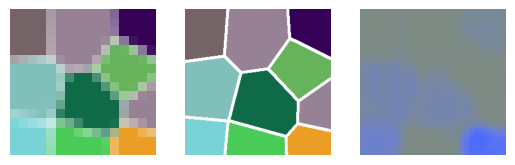

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.18it/s]


Epoch = 2, Train MSE = 0.06676559, Tune MSE = 0.06798015


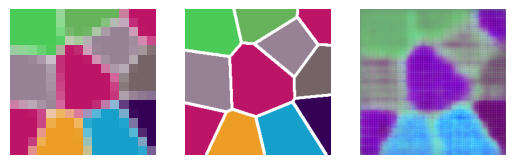

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.68it/s]


Epoch = 3, Train MSE = 0.05038434, Tune MSE = 0.051835217


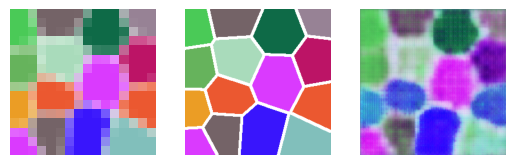

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.85it/s]


Epoch = 4, Train MSE = 0.049340483, Tune MSE = 0.050937437


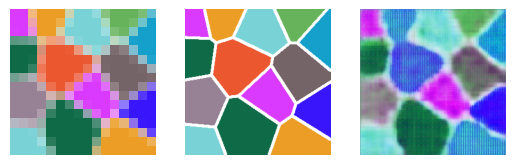

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 51.39it/s]


Epoch = 5, Train MSE = 0.02565059, Tune MSE = 0.026253067


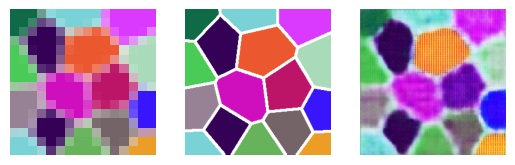

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 50.63it/s]


Epoch = 6, Train MSE = 0.022424204, Tune MSE = 0.022999603


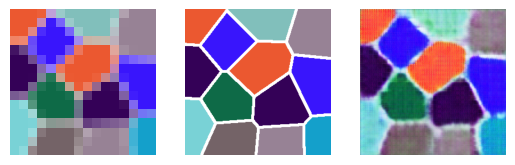

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 51.66it/s]


Epoch = 7, Train MSE = 0.021581978, Tune MSE = 0.022359474


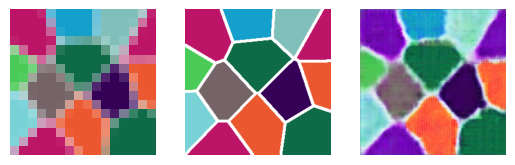

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 50.77it/s]


Epoch = 8, Train MSE = 0.02029222, Tune MSE = 0.021338174


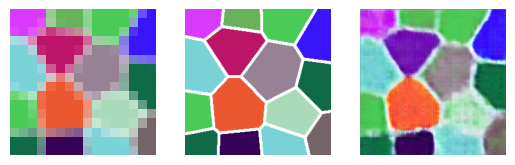

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 50.47it/s]


Epoch = 9, Train MSE = 0.019202985, Tune MSE = 0.020516552


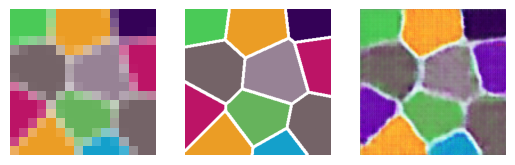

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.08it/s]


Epoch = 10, Train MSE = 0.018498823, Tune MSE = 0.019970508


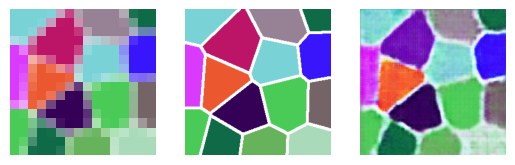

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.20it/s]


Epoch = 11, Train MSE = 0.017358774, Tune MSE = 0.019130277


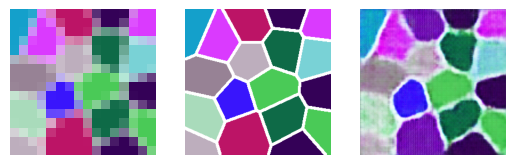

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:16<00:00, 49.64it/s]


Epoch = 12, Train MSE = 0.017351728, Tune MSE = 0.019322012


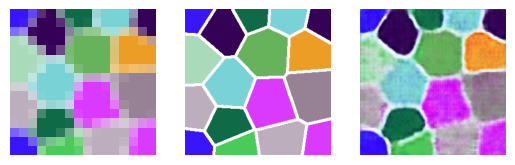

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.25it/s]


Epoch = 13, Train MSE = 0.016329164, Tune MSE = 0.018518612


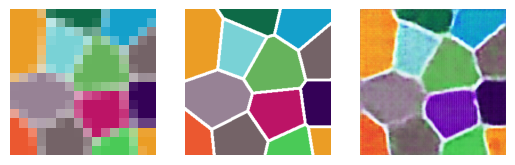

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.07it/s]


Epoch = 14, Train MSE = 0.016270902, Tune MSE = 0.018569466


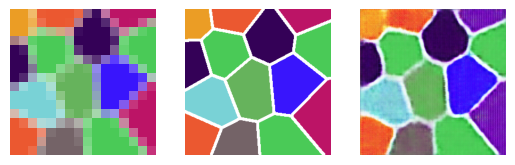

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.41it/s]


Epoch = 15, Train MSE = 0.015819905, Tune MSE = 0.018334653


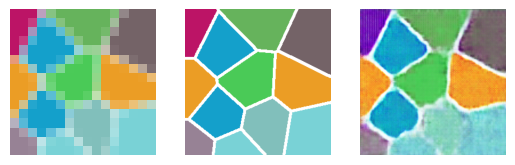

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.18it/s]


Epoch = 16, Train MSE = 0.015167457, Tune MSE = 0.017920835


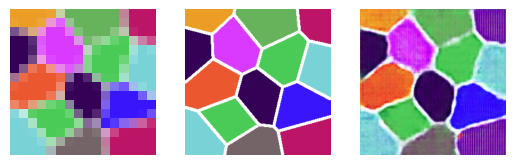

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.18it/s]


Epoch = 17, Train MSE = 0.010321755, Tune MSE = 0.013276967


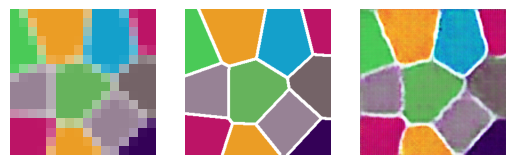

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 50.76it/s]


Epoch = 18, Train MSE = 0.00994221, Tune MSE = 0.013044546


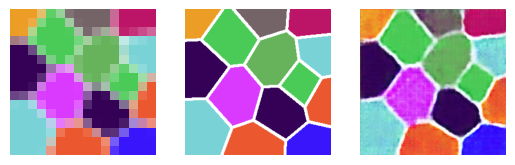

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 50.97it/s]


Epoch = 19, Train MSE = 0.009332427, Tune MSE = 0.012480363


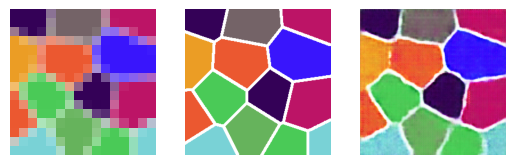

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.29it/s]


Epoch = 20, Train MSE = 0.00920639, Tune MSE = 0.012575709


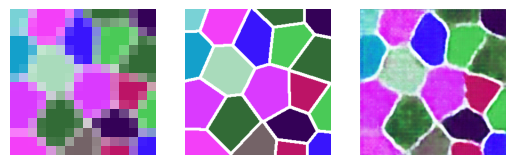

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.48it/s]


Epoch = 21, Train MSE = 0.008809075, Tune MSE = 0.012358544


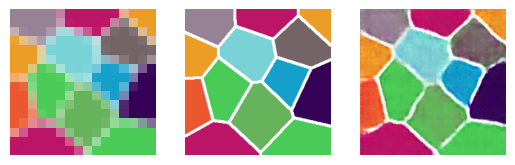

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 51.67it/s]


Epoch = 22, Train MSE = 0.008633645, Tune MSE = 0.01210498


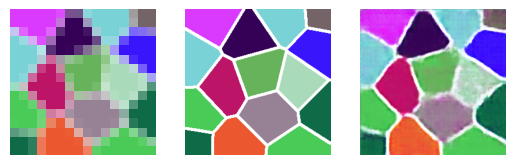

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 51.21it/s]


Epoch = 23, Train MSE = 0.00828617, Tune MSE = 0.011907617


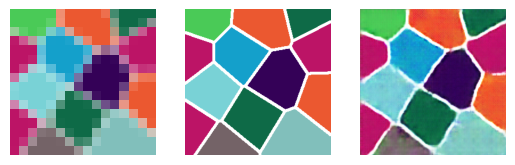

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 51.37it/s]


Epoch = 24, Train MSE = 0.008226067, Tune MSE = 0.011957716


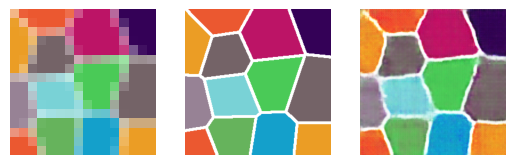

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.02it/s]


Epoch = 25, Train MSE = 0.007992681, Tune MSE = 0.011790523


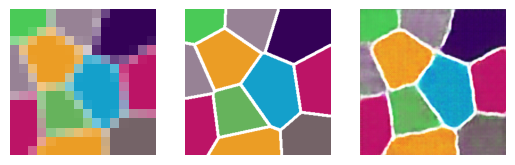

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.25it/s]


Epoch = 26, Train MSE = 0.007816708, Tune MSE = 0.011752332


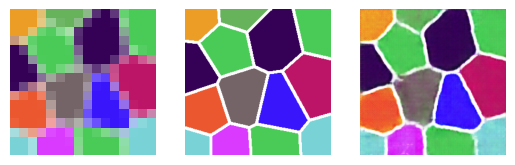

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 51.81it/s]


Epoch = 27, Train MSE = 0.0074736895, Tune MSE = 0.0113885095


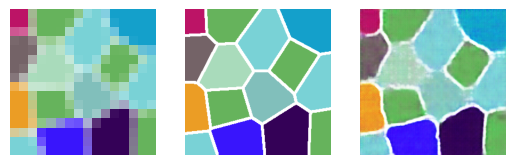

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.63it/s]


Epoch = 28, Train MSE = 0.007398016, Tune MSE = 0.011475994


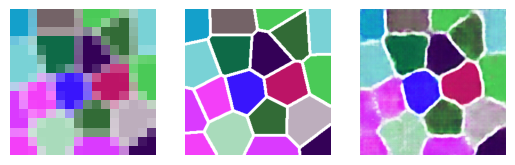

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.70it/s]


Epoch = 29, Train MSE = 0.007181957, Tune MSE = 0.011357153


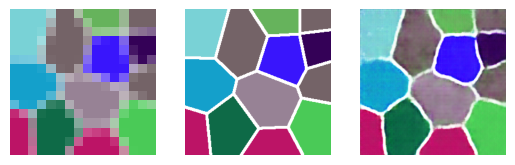

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.52it/s]


Epoch = 30, Train MSE = 0.006916684, Tune MSE = 0.011140407


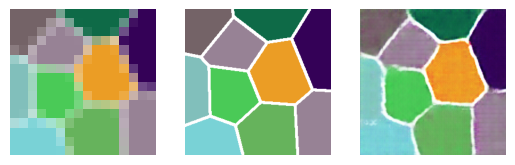

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.31it/s]


Epoch = 31, Train MSE = 0.0070004687, Tune MSE = 0.011318905


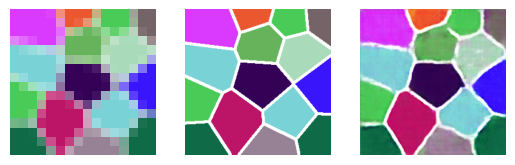

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.75it/s]


Epoch = 32, Train MSE = 0.006781704, Tune MSE = 0.01117001


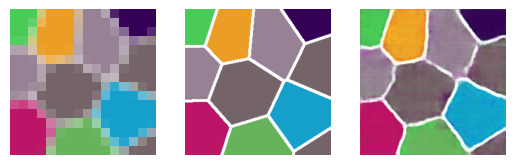

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.34it/s]


Epoch = 33, Train MSE = 0.006875391, Tune MSE = 0.011258325


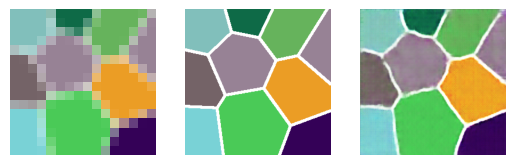

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.46it/s]


Epoch = 34, Train MSE = 0.0065865503, Tune MSE = 0.010905666


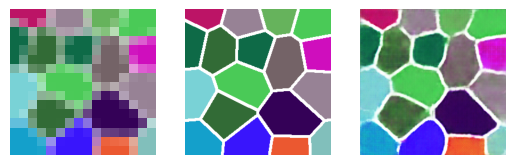

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.20it/s]


Epoch = 35, Train MSE = 0.00672447, Tune MSE = 0.01118654


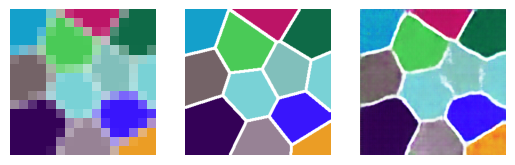

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 51.92it/s]


Epoch = 36, Train MSE = 0.0064001963, Tune MSE = 0.01085968


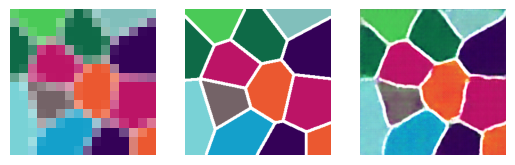

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.27it/s]


Epoch = 37, Train MSE = 0.0063168025, Tune MSE = 0.010816098


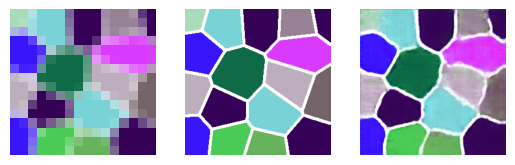

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.20it/s]


Epoch = 38, Train MSE = 0.006360786, Tune MSE = 0.010996821


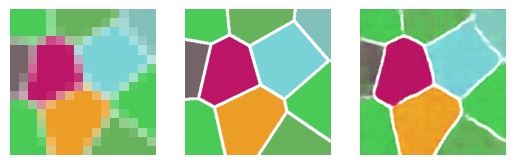

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.94it/s]


Epoch = 39, Train MSE = 0.0063497964, Tune MSE = 0.011193917


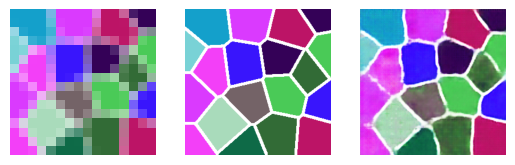

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.93it/s]


Epoch = 40, Train MSE = 0.0061367806, Tune MSE = 0.011132538


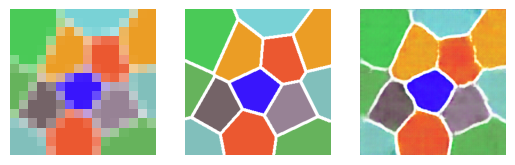

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 53.14it/s]


Epoch = 41, Train MSE = 0.0061626015, Tune MSE = 0.011032635


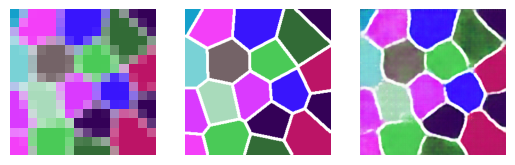

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.81it/s]


Epoch = 42, Train MSE = 0.006046664, Tune MSE = 0.010722017


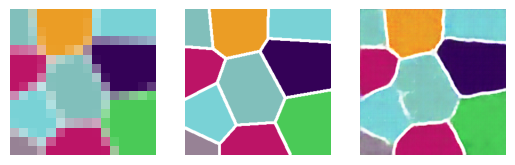

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.78it/s]


Epoch = 43, Train MSE = 0.0059458804, Tune MSE = 0.010746295


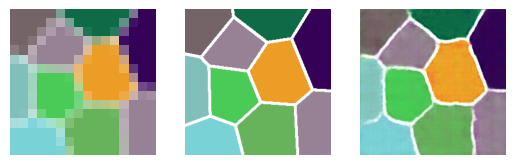

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 53.09it/s]


Epoch = 44, Train MSE = 0.0059992336, Tune MSE = 0.010779154


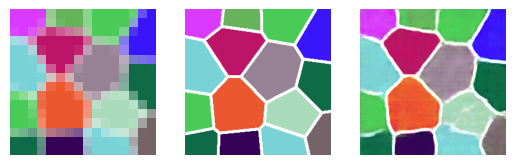

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.95it/s]


Epoch = 45, Train MSE = 0.0056190044, Tune MSE = 0.0104879355


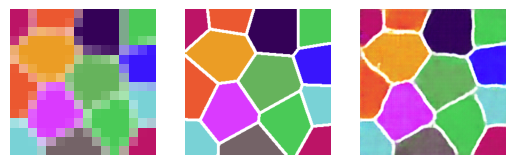

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 51.49it/s]


Epoch = 46, Train MSE = 0.00554198, Tune MSE = 0.010588703


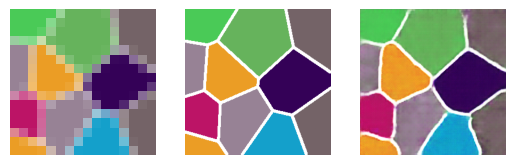

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 53.15it/s]


Epoch = 47, Train MSE = 0.00564261, Tune MSE = 0.010649452


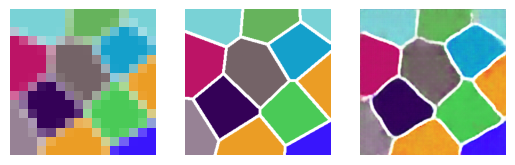

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.92it/s]


Epoch = 48, Train MSE = 0.0056120954, Tune MSE = 0.0106486


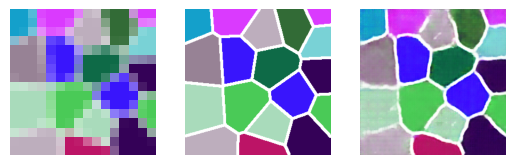

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.57it/s]


Epoch = 49, Train MSE = 0.005492379, Tune MSE = 0.010480064


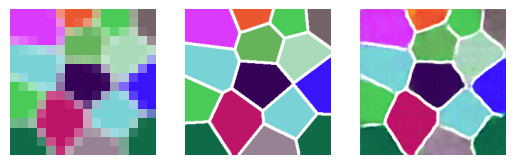

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.96it/s]


Epoch = 50, Train MSE = 0.0056615267, Tune MSE = 0.010926352


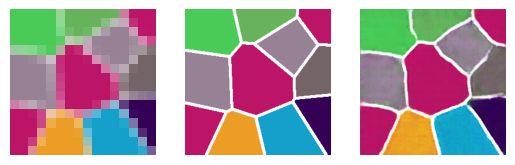

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 53.06it/s]


Epoch = 51, Train MSE = 0.005436844, Tune MSE = 0.010636


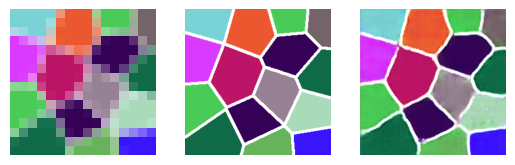

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.34it/s]


Epoch = 52, Train MSE = 0.0053447364, Tune MSE = 0.010744614


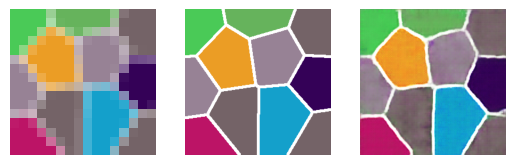

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 51.05it/s]


Epoch = 53, Train MSE = 0.005304536, Tune MSE = 0.010571608


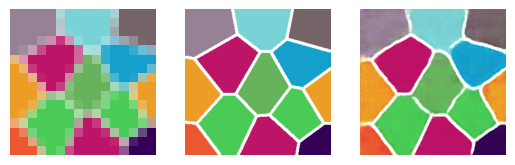

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.63it/s]


Epoch = 54, Train MSE = 0.005541927, Tune MSE = 0.011001387


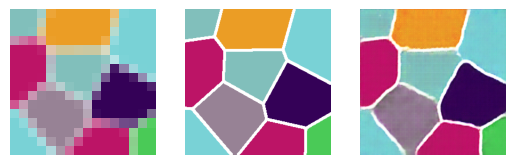

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.64it/s]


Epoch = 55, Train MSE = 0.005287909, Tune MSE = 0.010759636


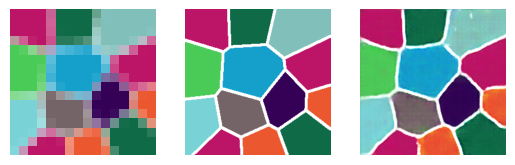

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.74it/s]


Epoch = 56, Train MSE = 0.005214226, Tune MSE = 0.010602114


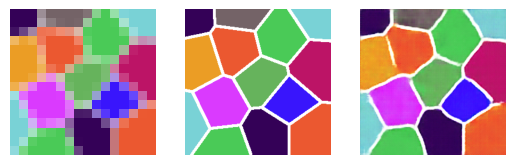

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.41it/s]


Epoch = 57, Train MSE = 0.005086405, Tune MSE = 0.010545391


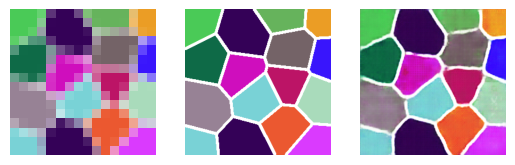

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.19it/s]


Epoch = 58, Train MSE = 0.005127613, Tune MSE = 0.010554593


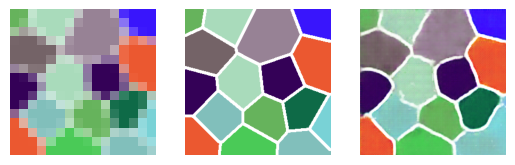

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 51.99it/s]


Epoch = 59, Train MSE = 0.004997707, Tune MSE = 0.010562082


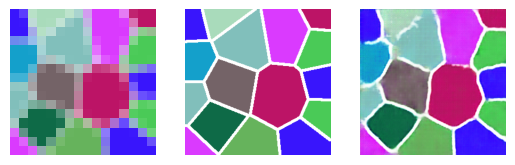

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.99it/s]


Epoch = 60, Train MSE = 0.004937939, Tune MSE = 0.010522629


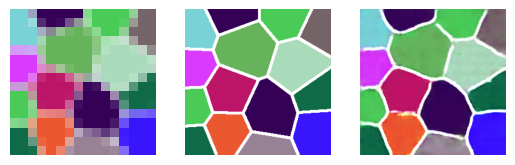

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.39it/s]


Epoch = 61, Train MSE = 0.0047878916, Tune MSE = 0.010343182


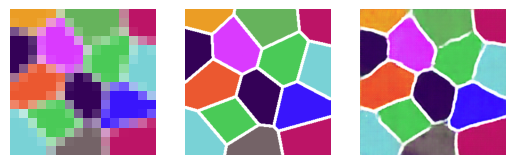

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.54it/s]


Epoch = 62, Train MSE = 0.005026417, Tune MSE = 0.010625921


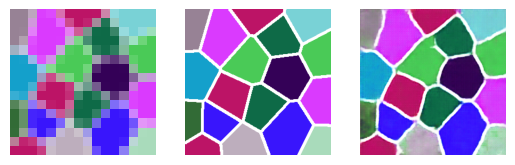

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.73it/s]


Epoch = 63, Train MSE = 0.004855198, Tune MSE = 0.010401349


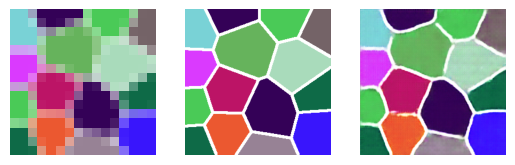

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.17it/s]


Epoch = 64, Train MSE = 0.0048662554, Tune MSE = 0.010600371


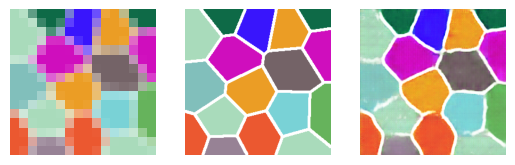

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.60it/s]


Epoch = 65, Train MSE = 0.004910739, Tune MSE = 0.010367477


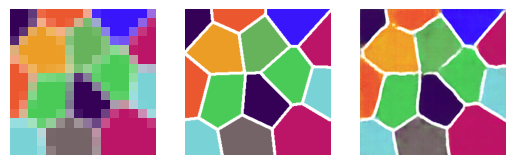

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.63it/s]


Epoch = 66, Train MSE = 0.004745352, Tune MSE = 0.010538841


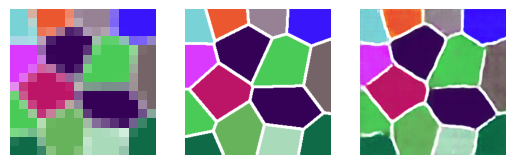

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.53it/s]


Epoch = 67, Train MSE = 0.0047547454, Tune MSE = 0.010478376


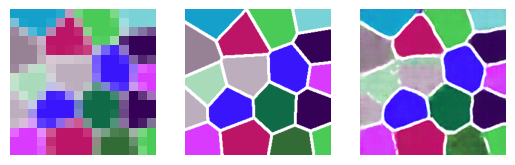

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.21it/s]


Epoch = 68, Train MSE = 0.0045964997, Tune MSE = 0.010369877


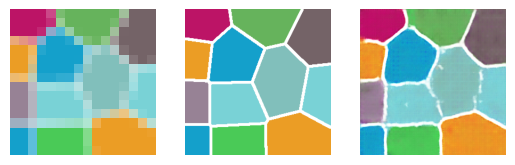

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.64it/s]


Epoch = 69, Train MSE = 0.004509947, Tune MSE = 0.010284227


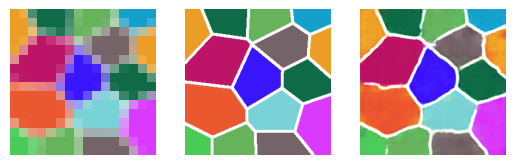

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.73it/s]


Epoch = 70, Train MSE = 0.004586037, Tune MSE = 0.010340859


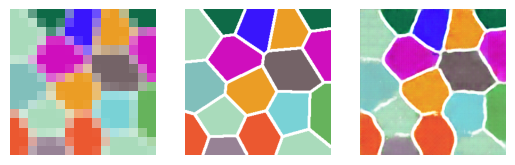

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.81it/s]


Epoch = 71, Train MSE = 0.0044598044, Tune MSE = 0.010340071


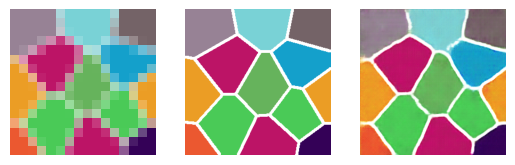

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.14it/s]


Epoch = 72, Train MSE = 0.0044914903, Tune MSE = 0.010420955


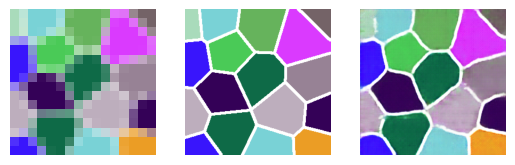

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.56it/s]


Epoch = 73, Train MSE = 0.004488014, Tune MSE = 0.010298936


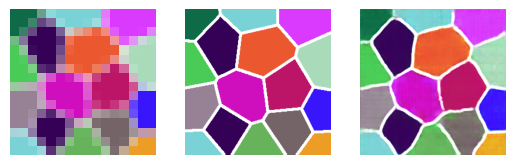

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.51it/s]


Epoch = 74, Train MSE = 0.0043459926, Tune MSE = 0.010305396


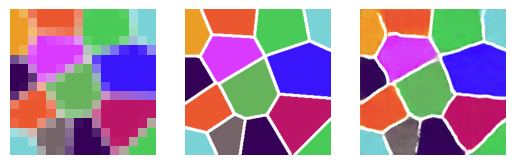

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.23it/s]


Epoch = 75, Train MSE = 0.0044021653, Tune MSE = 0.010439903


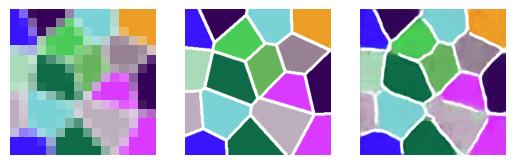

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.47it/s]


Epoch = 76, Train MSE = 0.0043458347, Tune MSE = 0.010236786


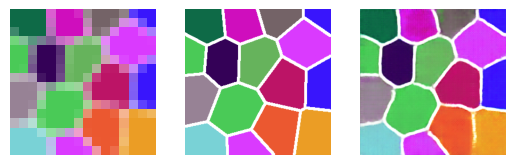

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.35it/s]


Epoch = 77, Train MSE = 0.004430364, Tune MSE = 0.0105413105


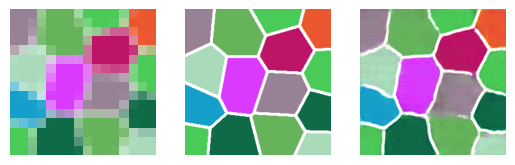

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.63it/s]


Epoch = 78, Train MSE = 0.004294861, Tune MSE = 0.010380403


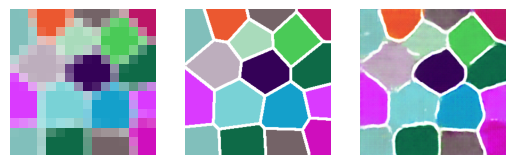

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.11it/s]


Epoch = 79, Train MSE = 0.0042688665, Tune MSE = 0.010364438


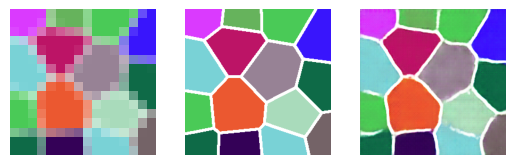

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.64it/s]


Epoch = 80, Train MSE = 0.0042806417, Tune MSE = 0.010431964


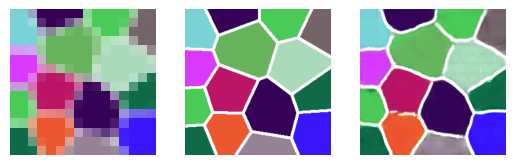

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.57it/s]


Epoch = 81, Train MSE = 0.0043048216, Tune MSE = 0.01034891


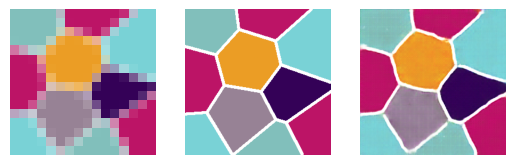

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.58it/s]


Epoch = 82, Train MSE = 0.004181939, Tune MSE = 0.010256006


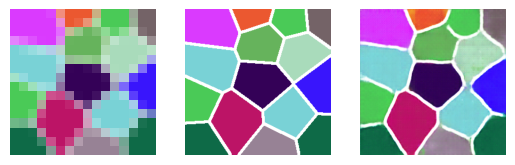

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.38it/s]


Epoch = 83, Train MSE = 0.0042856713, Tune MSE = 0.0103538595


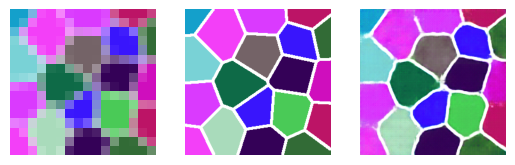

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.11it/s]


Epoch = 84, Train MSE = 0.0041920026, Tune MSE = 0.010636405


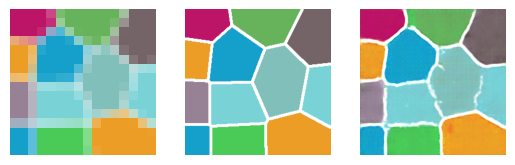

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.61it/s]


Epoch = 85, Train MSE = 0.0040776255, Tune MSE = 0.01036552


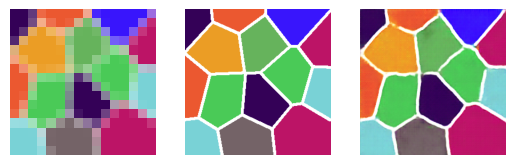

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.69it/s]


Epoch = 86, Train MSE = 0.004334801, Tune MSE = 0.010395356


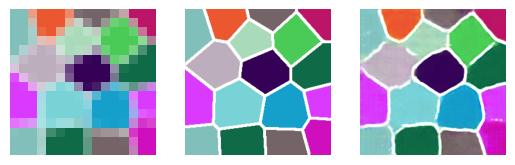

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.45it/s]


Epoch = 87, Train MSE = 0.0040661083, Tune MSE = 0.010335931


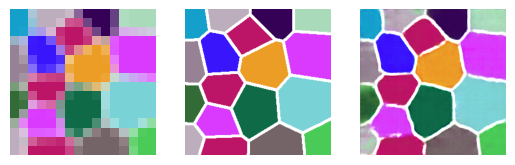

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.60it/s]


Epoch = 88, Train MSE = 0.004032984, Tune MSE = 0.010266632


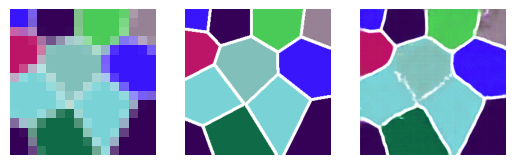

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.52it/s]


Epoch = 89, Train MSE = 0.004034431, Tune MSE = 0.010387055


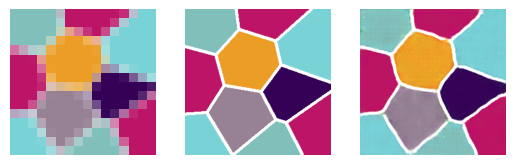

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.27it/s]


Epoch = 90, Train MSE = 0.004158173, Tune MSE = 0.010404397


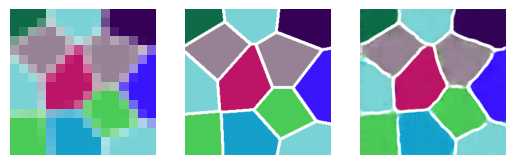

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.68it/s]


Epoch = 91, Train MSE = 0.004083996, Tune MSE = 0.010171548


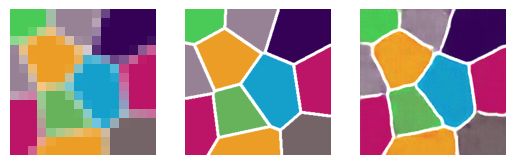

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.53it/s]


Epoch = 92, Train MSE = 0.0039834105, Tune MSE = 0.010520229


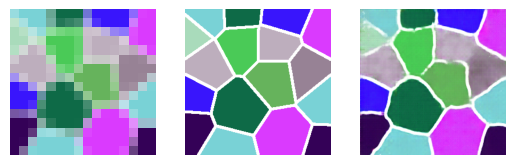

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.66it/s]


Epoch = 93, Train MSE = 0.003998761, Tune MSE = 0.010356766


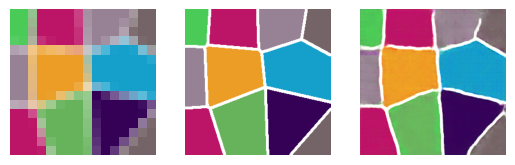

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.30it/s]


Epoch = 94, Train MSE = 0.003895131, Tune MSE = 0.010437953


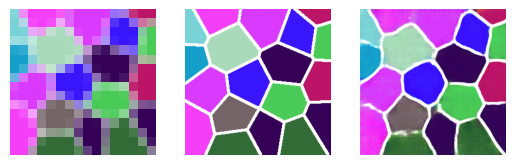

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.57it/s]


Epoch = 95, Train MSE = 0.00395271, Tune MSE = 0.01025249


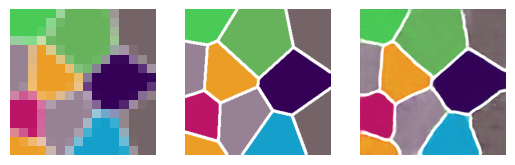

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.72it/s]


Epoch = 96, Train MSE = 0.003820659, Tune MSE = 0.010498513


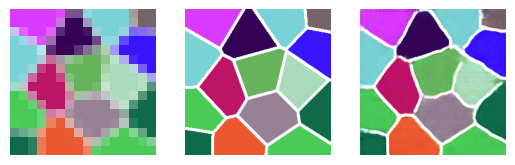

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.68it/s]


Epoch = 97, Train MSE = 0.003993268, Tune MSE = 0.010503376


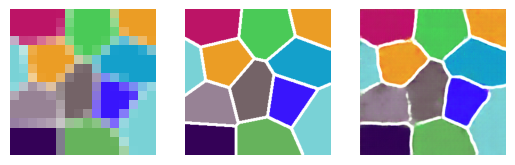

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.44it/s]


Epoch = 98, Train MSE = 0.0038603619, Tune MSE = 0.010358315


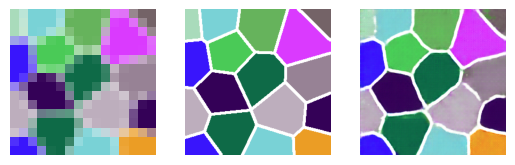

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 52.78it/s]


Epoch = 99, Train MSE = 0.00367698, Tune MSE = 0.010177979


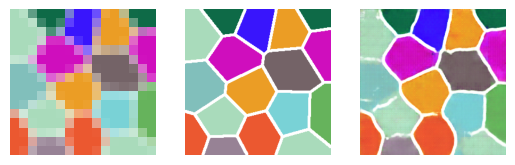

100%|████████████████████████████████████████████████████████████████████████████████| 800/800 [00:15<00:00, 53.03it/s]


Epoch = 100, Train MSE = 0.0037969407, Tune MSE = 0.010290274


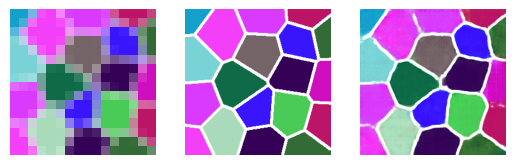

In [10]:
train_mse, tune_mse = train(model, x_train, y_train, x_tune, y_tune, batch_size = 1, n_epochs = 100)

(0.0, 0.06)

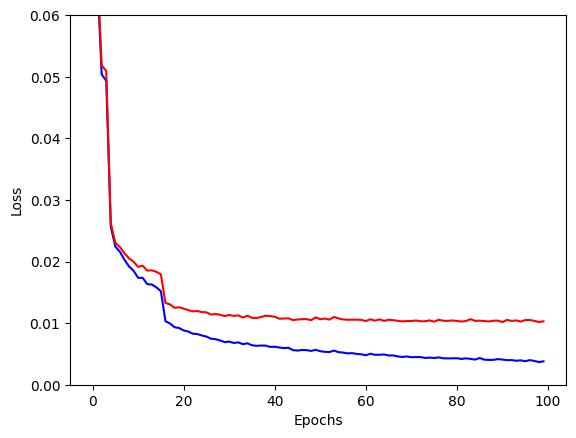

In [11]:
plt.plot(train_mse, c = 'b')
plt.plot(tune_mse, c = 'r')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.ylim([0,0.06])

In [12]:
predictions = model.predict(x_test)

ssim_all = [ssim(y_test[i].squeeze(),predictions[i].squeeze(), channel_axis=-1, data_range=1) for i in range(100)]
print('Average SSIM = '+str(np.mean(ssim_all)))
print('Min SSIM = '+str(np.min(ssim_all)))
print('Max SSIM = '+str(np.max(ssim_all)))
print('STD SSIM = '+str(np.std(ssim_all)))
print('SSIM = '+str(np.round(np.mean(ssim_all),2))+'['+str(np.round(np.percentile(ssim_all,2.5),2))+', '+str(np.round(np.percentile(ssim_all,97.5),2))+'] 95% CI')


Average SSIM = 0.8219144
Min SSIM = 0.75816184
Max SSIM = 0.8749039
STD SSIM = 0.029485669
SSIM = 0.82[0.77, 0.87] 95% CI


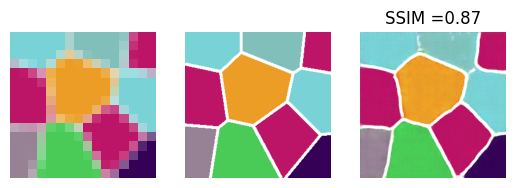

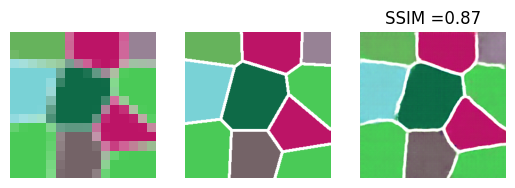

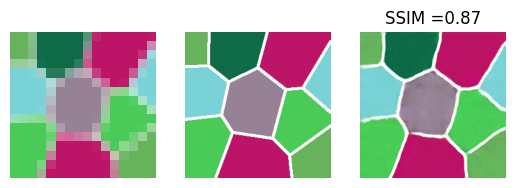

In [13]:
#### 3 best images #####
idx = np.argpartition(ssim_all, -3)[-3:]
for i in idx:  
    plt.figure()
    plt.subplot(1,3,1)
    plt.imshow(x_test[i])
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(y_test[i])
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(predictions[i])
    plt.axis('off')
    plt.title('SSIM ='+str(np.round(ssim_all[i],2)))

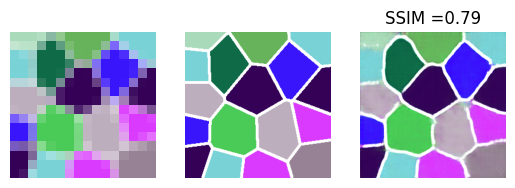

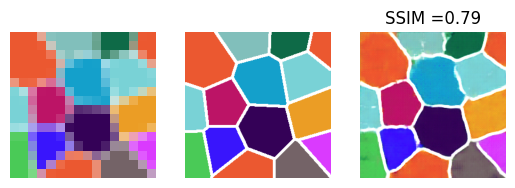

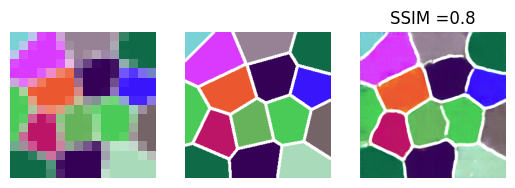

In [14]:
#### 3 worst images #####
idx = np.argpartition(ssim_all, -3)[:3]
for i in idx:  
    plt.figure()
    plt.subplot(1,3,1)
    plt.imshow(x_test[i])
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(y_test[i])
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(predictions[i])
    plt.axis('off')
    plt.title('SSIM ='+str(np.round(ssim_all[i],2)))